## Oakland County Mortgage Prediction

### Project Description


The goal of this project is to predict the credit decision made by financial institutions on home mortgage. Specifically, I investigate the conventional loan by utilizing Home Mortgage Disclosure Act (HMDA) data of Oakland County, Michigan. It assists potential home buyers in understanding key aspects of loan eligibility and helps them build favored records for future mortgage application.

The Home Mortgage Disclosure Act (HMDA) requires many financial institutions to maintain, report, and publicly disclose loan-level information about mortgages. These data help show whether lenders are serving the housing needs of their communities; they give public officials information that helps them make decisions and policies; and they shed light on lending patterns that could be discriminatory. The public data are modified to protect applicant and borrower privacy.

This notbook includes data description, EDA procedure, model building and training, results, and conclusions. The unsupervised machine learning methods are applied to classify the approval or deny on home mortgage:
1. Hierarchical clustering 
2. K-means clustering

The primary metric to evaluate the effectiveness of the model is accuracy. There are some hyperparameter tuning effort in order to get better accuracy.

### 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import itertools

In [2]:
# Read data
data = pd.read_csv('Oakland_county_hmda_2023.csv')

The dataset has 19,471 rows and 99 columns, indicating that a total of 19,471 conventional home purcahse loan applied in Oakland County in 2023. There are 99 features of each data point.

In [3]:
data.shape

(19471, 99)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19471 entries, 0 to 19470
Data columns (total 99 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   activity_year                             19471 non-null  int64  
 1   lei                                       19471 non-null  object 
 2   derived_msa-md                            19471 non-null  int64  
 3   state_code                                19470 non-null  object 
 4   county_code                               19471 non-null  int64  
 5   census_tract                              19344 non-null  float64
 6   conforming_loan_limit                     19438 non-null  object 
 7   derived_loan_product_type                 19471 non-null  object 
 8   derived_dwelling_category                 19471 non-null  object 
 9   derived_ethnicity                         19471 non-null  object 
 10  derived_race                      

In [5]:
data.columns

Index(['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code',
       'census_tract', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'action_taken', 'purchaser_type', 'preapproval',
       'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_

Investigate mortgages for first lien and owner-occupied, 1-4 family homes

In [6]:
# filter out non first lien loan
data = data[data['lien_status'] == 1]
# filter out non principle dewelling
data = data[data['occupancy_type'] == 1]
# filter out non 1-4 family homes: Site-Built homes
data = data[data['derived_dwelling_category'] == 'Single Family (1-4 Units):Site-Built']

In [7]:
unrelated_cols = ['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code',
               'census_tract', 'conforming_loan_limit', 'derived_loan_product_type', 'derived_dwelling_category',
                'loan_type', 'loan_purpose',
              'lien_status','hoepa_status','total_loan_costs', 'total_points_and_fees', 'origination_charges',
              'discount_points', 'lender_credits','prepayment_penalty_term', 'intro_rate_period','occupancy_type',
               'multifamily_affordable_units',
               'applicant_ethnicity-1', 'applicant_ethnicity-2',
                'applicant_ethnicity-3', 'applicant_ethnicity-4',
                'applicant_ethnicity-5', 'co-applicant_ethnicity-1',
                'co-applicant_ethnicity-2', 'co-applicant_ethnicity-3',
                'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5',
               'applicant_ethnicity_observed', 'co-applicant_ethnicity_observed',
               'applicant_race-1', 'applicant_race-2', 'applicant_race-3',
               'applicant_race-4', 'applicant_race-5', 'co-applicant_race-1',
               'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4',
               'co-applicant_race-5', 'applicant_race_observed',
               'co-applicant_race_observed', 'applicant_sex', 'co-applicant_sex',
               'applicant_sex_observed', 'co-applicant_sex_observed',
               'aus-1', 'aus-2', 'aus-3', 'aus-4',
               'aus-5', 'denial_reason-1', 'denial_reason-2', 'denial_reason-3',
               'denial_reason-4', 'applicant_age_above_62', 'co-applicant_age_above_62',
               'tract_population', 'tract_minority_population_percent',
               'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
               'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
               'tract_median_age_of_housing_units']

After going through all the columns of the HMDA data, I removed above columns before doing further analysis.

Reference: https://www.consumerfinance.gov/rules-policy/regulations/1003/interp-4/#4-a-11-Interp-5

In [8]:
df = data.drop(unrelated_cols, axis = 1)
df.shape

(16123, 31)

In [9]:
df.head()

,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,...,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_age,co-applicant_age,submission_of_application,initially_payable_to_institution
0,Ethnicity Not Available,Race Not Available,Sex Not Available,6,3,2,2,2,2,125000.0,...,5,1,NaN,NaN,9,9,8888,8888,3,3
1,Ethnicity Not Available,Race Not Available,Sex Not Available,6,3,2,2,2,2,165000.0,...,5,1,NaN,NaN,9,9,8888,8888,3,3
2,Ethnicity Not Available,Race Not Available,Sex Not Available,6,3,2,2,2,2,115000.0,...,5,1,NaN,NaN,9,9,8888,8888,3,3
10,Not Hispanic or Latino,White,Joint,6,8,2,2,2,2,265000.0,...,5,1,124.0,NaN,9,9,45-54,45-54,3,3
14,Not Hispanic or Latino,Asian,Male,1,71,2,2,2,2,605000.0,...,5,1,263.0,41,9,1,35-44,35-44,1,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16123 entries, 0 to 19470
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   derived_ethnicity                         16123 non-null  object 
 1   derived_race                              16123 non-null  object 
 2   derived_sex                               16123 non-null  object 
 3   action_taken                              16123 non-null  int64  
 4   purchaser_type                            16123 non-null  int64  
 5   preapproval                               16123 non-null  int64  
 6   reverse_mortgage                          16123 non-null  int64  
 7   open-end_line_of_credit                   16123 non-null  int64  
 8   business_or_commercial_purpose            16123 non-null  int64  
 9   loan_amount                               16123 non-null  float64
 10  loan_to_value_ratio                    

The reduced dataframe has 31 features. 2 columns have float64 data type, 17 columns has int64 datatype and 12 columns have object data type.

The code of action_taken based on hmda comments:
1. covered loan originated
2. covered loan purchased
3. application approved but not accepted
4. application denied
5. application withdrawn
6. file closed for incompleteness
7. preapproval request denied
8. preapproval request approved but not accepted


In [11]:
df.action_taken.value_counts()

action_taken
1    10867
4     2330
6     1380
3      765
5      357
2      245
8      148
7       31
Name: count, dtype: int64

Analyze approved and denied loans only

In [12]:
df = df[df['action_taken'].isin ([1, 4])]

In [13]:
# Check for missing values in the dataset
missing_values =  df.isnull().sum()

# Display the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

# Verify if the dataset is clean (no missing values)
if missing_values.sum() == 0:
    print("\nThe dataset is clean: No missing values found.")
else:
    print(f"\nThe dataset contains {missing_values.sum()} missing values.")

Missing values in each column:
derived_ethnicity                              0
derived_race                                   0
derived_sex                                    0
action_taken                                   0
purchaser_type                                 0
preapproval                                    0
reverse_mortgage                               0
open-end_line_of_credit                        0
business_or_commercial_purpose                 0
loan_amount                                    0
loan_to_value_ratio                         2321
interest_rate                               2309
rate_spread                                 2338
loan_term                                      5
negative_amortization                          0
interest_only_payment                          0
balloon_payment                                0
other_nonamortizing_features                   0
property_value                              2342
construction_method                   

There are missing data in seven columns. Five of these columns have significant number of missing data and two of columns, loan_term and income columns, have relative fewer missing data. First of all, I dropped the missing data in these two columns.

In [14]:
# drop the specific rows where at least one element in subset of cols is missing
df = df.dropna(subset = ['loan_term', 'income'])

In [15]:
# check the remaining number of denied loan application
print('The number of denied loan application: ', len(df[df['action_taken']==4]))

The number of denied loan application:  2285


In [16]:
print(len(df[(df['action_taken']==4) & (df['loan_to_value_ratio'].isna())]))
print(len(df[(df['action_taken']==4) & (df['interest_rate'].isna())]))
print(len(df[(df['action_taken']==4) & (df['rate_spread'].isna())]))
print(len(df[(df['action_taken']==4) & (df['property_value'].isna())]))
print(len(df[(df['action_taken']==4) & (df['debt_to_income_ratio'].isna())]))

2264
2264
2264
2264
2264


Using masking to reveal the number of missing values in denied applications, there are over 2200 missing values in loan_to_value_ratio, interest_rate, rate_spread, property_value and debt_to_income_ratio. The number of missing data in each of these columns is close to the total number of denied loan applications. Therefore, I need to impute data instead of simply dropping these nan values.

Impute property_value

In [17]:
# convert column to numeric typesreplace any str with nan
df['property_value'] = pd.to_numeric(df['property_value'], errors='coerce')
df['property_value'] = df['property_value'].fillna(df['loan_amount']/0.8)

Impute missing interest_rate and rate_spread to averege values

In [18]:
# impute interest_rate
df['interest_rate'] = pd.to_numeric(df['interest_rate'], errors='coerce')
df['interest_rate'] = df['interest_rate'].fillna(df['interest_rate'].mean())
# print(df['interest_rate'].unique())
# # impute rate_spread
df['rate_spread'] = pd.to_numeric(df['rate_spread'], errors='coerce')
df['rate_spread'] = df['rate_spread'].fillna(df['rate_spread'].mean())


Impute loan_to_value ratio feature as loan_amonut divide by property_value

In [19]:
# impute loan_to_value ratio
df['loan_to_value_ratio'] = pd.to_numeric(df['loan_to_value_ratio'], errors='coerce')
df['loan_to_value_ratio'] = df['loan_to_value_ratio'].fillna(df['loan_amount']/df['property_value'])

A closer look at column of debt_to_income_ratio is included below where I encoded the columns based on its unique values.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12967 entries, 14 to 19470
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   derived_ethnicity                         12967 non-null  object 
 1   derived_race                              12967 non-null  object 
 2   derived_sex                               12967 non-null  object 
 3   action_taken                              12967 non-null  int64  
 4   purchaser_type                            12967 non-null  int64  
 5   preapproval                               12967 non-null  int64  
 6   reverse_mortgage                          12967 non-null  int64  
 7   open-end_line_of_credit                   12967 non-null  int64  
 8   business_or_commercial_purpose            12967 non-null  int64  
 9   loan_amount                               12967 non-null  float64
 10  loan_to_value_ratio                   

In [21]:
print('unique value of derived_ethnicity: ',df['derived_ethnicity'].unique())
print('unique value of derived_race: ',df['derived_race'].unique())
print('unique value of derived_sex: ',df['derived_sex'].unique())
print('unique value of total_units: ',df['total_units'].unique())
print('unique value of loan_term: ',df['loan_term'].unique())
print('unique value of debt_to_income_ratio:' ,df['debt_to_income_ratio'].unique())

unique value of derived_ethnicity:  ['Not Hispanic or Latino' 'Ethnicity Not Available' 'Joint'
 'Hispanic or Latino' 'Free Form Text Only']
unique value of derived_race:  ['Asian' 'White' 'Race Not Available' 'Joint' 'Black or African American'
 '2 or more minority races' 'Native Hawaiian or Other Pacific Islander'
 'American Indian or Alaska Native']
unique value of derived_sex:  ['Male' 'Joint' 'Female' 'Sex Not Available']
unique value of total_units:  ['1' '2' '4' '3']
unique value of loan_term:  ['360' '180' '219' '318' '240' '120' '371' '208' '300' '192' 'Exempt'
 '270' '372' '480' '179' '361' '368' '384' '378' '258' '66' '369' '228'
 '189' '367' '12' '370' '84']
unique value of debt_to_income_ratio: ['41' '20%-<30%' '42' '38' '30%-<36%' '49' '45' '48' nan '<20%' '36' '40'
 '46' '39' '43' '47' '37' '44' '50%-60%' 'Exempt' '>60%']


 Remove 'Free Form Text Only' from column of derived_ethnicity

In [22]:
# filter data of undefined ethnicity
df=df[df['derived_ethnicity'] != 'Free Form Text Only']

The data type of loan_term and debt_to_income_ratio columns are objects but they should be float type of data. After looking at data in these columns, the string 'Excempt' is the value that makes these columns being object type. The 'Excempt' only represents smaller portion of data in these columns so I removed them.

In [23]:
df = df[~df[['loan_term', 'debt_to_income_ratio']].isin(['Exempt']).any(axis=1)]
df['loan_term'] = df['loan_term'].astype('float')
df['total_units'] = df['total_units'].astype('float')

In [24]:
# Check the number of denied loan again
print('The number of denied loan application: ', len(df[df['action_taken']==4]))

The number of denied loan application:  2263


Take a closer look at the applicant_age and co-applicant_age columns. The age of applicants is divided by 7 groups. There is one abnormal value in both applicant_age and co-applicant_age columns. I removed the abnormal value from applicant_age column only. I left the co-applicant_age column unchanged as the abnormal value represents a great portion of data in that column.

In [25]:
# Display the unique value of applicant_age and co-applicant_age
print('Unique value of applicant_age: ', df['applicant_age'].unique())
print('Unique value of co-applicant_age: ', df['co-applicant_age'].unique())

Unique value of applicant_age:  ['35-44' '45-54' '55-64' '25-34' '65-74' '>74' '<25' '8888']
Unique value of co-applicant_age:  ['35-44' '45-54' '9999' '55-64' '65-74' '25-34' '<25' '>74']


In [26]:
# Remove the data points including '8888' and '9999' in these two columns
df = df[df['applicant_age'] != '8888']
print(len(df[df['co-applicant_age'] == '9999']))

8022


In [27]:
# use LabelEncoder to assigns a numerical label to each unique category in age column
encoder = LabelEncoder()
df['applicant_age'] = encoder.fit_transform(df['applicant_age'])
df['co-applicant_age'] = encoder.fit_transform(df['co-applicant_age'])

In [28]:
# use LabelEncoder to assigns a numerical label to each unique category in ethnicity, race and sex columns
df['derived_ethnicity'] = encoder.fit_transform(df['derived_ethnicity'])
df['derived_race'] = encoder.fit_transform(df['derived_race'])
df['derived_sex'] = encoder.fit_transform(df['derived_sex'])
df['debt_to_income_ratio'] = encoder.fit_transform(df['debt_to_income_ratio'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12894 entries, 14 to 19470
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   derived_ethnicity                         12894 non-null  int32  
 1   derived_race                              12894 non-null  int32  
 2   derived_sex                               12894 non-null  int32  
 3   action_taken                              12894 non-null  int64  
 4   purchaser_type                            12894 non-null  int64  
 5   preapproval                               12894 non-null  int64  
 6   reverse_mortgage                          12894 non-null  int64  
 7   open-end_line_of_credit                   12894 non-null  int64  
 8   business_or_commercial_purpose            12894 non-null  int64  
 9   loan_amount                               12894 non-null  float64
 10  loan_to_value_ratio                   

All data is converted to numerical, based on dataset information.

In [30]:
# Display the number of unique values in each column
unique_counts = df.nunique()
print("Number of unique values per column:")
print(unique_counts[unique_counts>1])

Number of unique values per column:
derived_ethnicity                      4
derived_race                           8
derived_sex                            4
action_taken                           2
purchaser_type                         9
preapproval                            2
open-end_line_of_credit                2
business_or_commercial_purpose         2
loan_amount                          207
loan_to_value_ratio                 2105
interest_rate                        626
rate_spread                         3033
loan_term                             27
interest_only_payment                  2
balloon_payment                        2
other_nonamortizing_features           2
property_value                       370
total_units                            4
income                               740
debt_to_income_ratio                  20
applicant_credit_score_type           10
co-applicant_credit_score_type         8
applicant_age                          7
co-applicant_age     

### Outlier Detection and Treatment

In [31]:
numerical_cols = df.select_dtypes(include='number')
print(numerical_cols.columns)
print(len(numerical_cols.columns))

Index(['derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'purchaser_type', 'preapproval', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'loan_term', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_units', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_age', 'co-applicant_age',
       'submission_of_application', 'initially_payable_to_institution'],
      dtype='object')
31


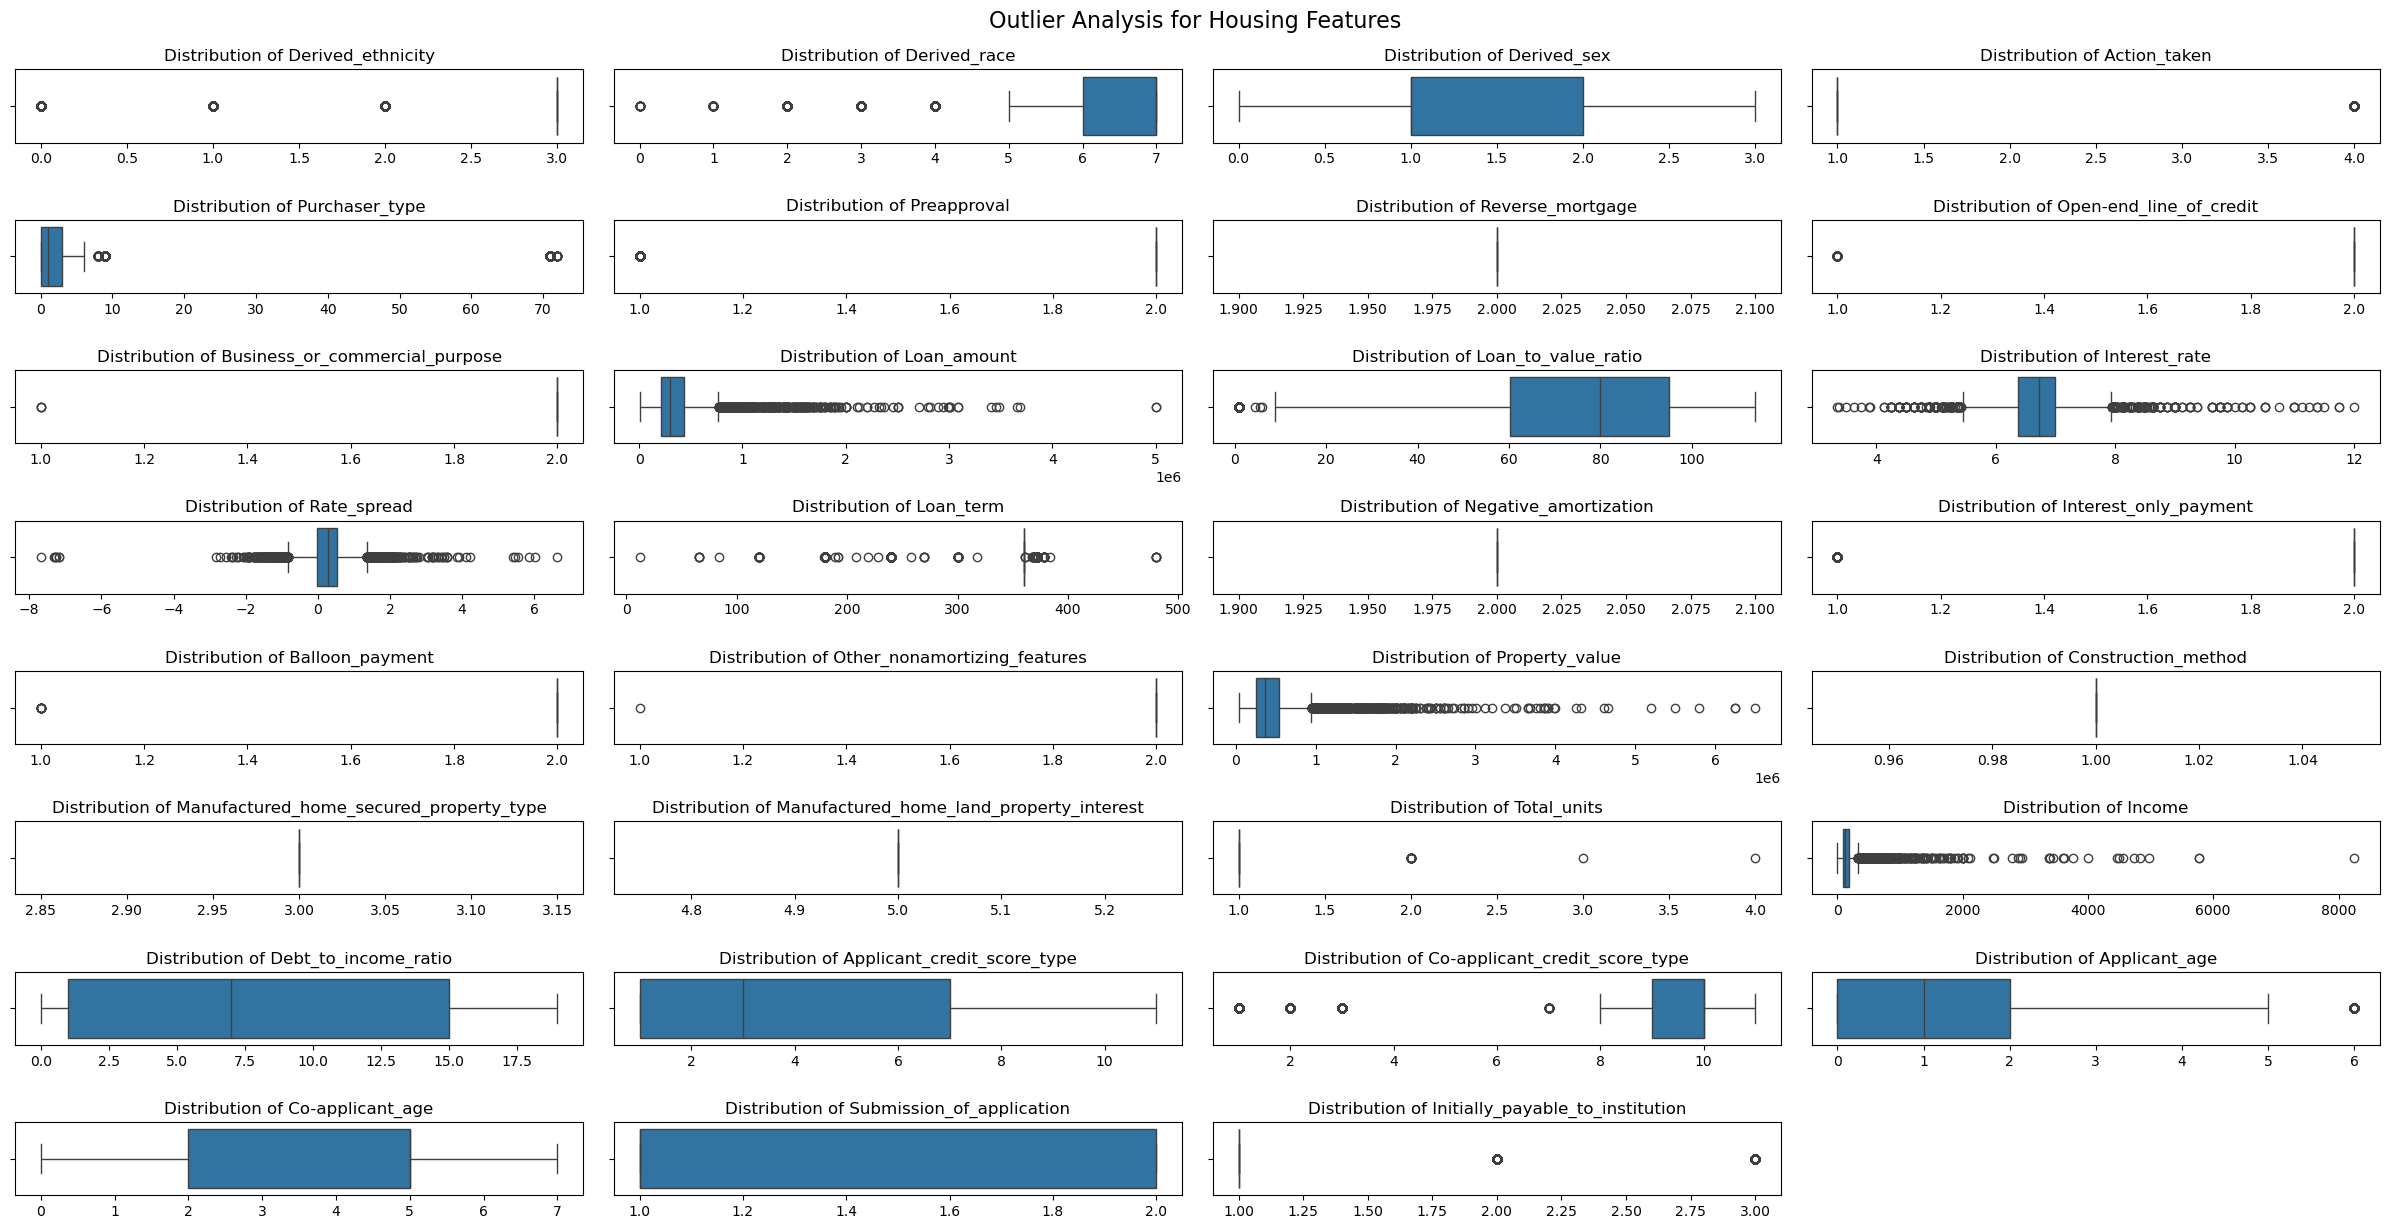

In [32]:
plt.figure(figsize=(24, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(8, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Distribution of {col.capitalize()}', fontsize=12)
    plt.xlabel('')
    
plt.tight_layout()
plt.suptitle('Outlier Analysis for Housing Features', fontsize=16, y=1.02)
plt.show()  

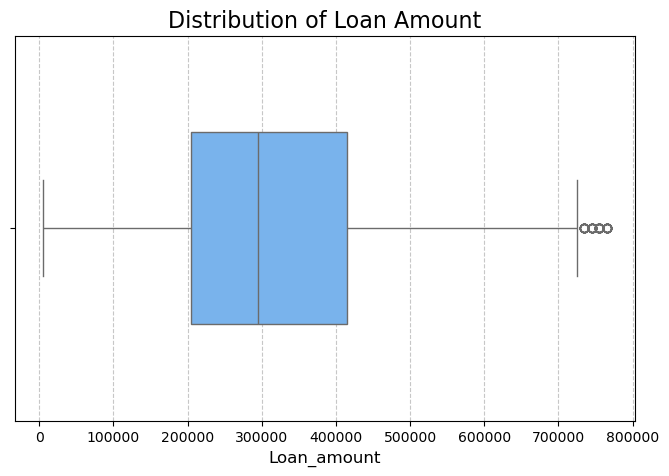

In [33]:
#  Loan amount and property value have many outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def plot_boxplot(df, column, color, title):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], color=color, width=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
df = remove_outliers(df, 'loan_amount')
plot_boxplot(df, 'loan_amount', '#66b3ff', 'Distribution of Loan Amount')

In [34]:
df.shape

(12410, 31)

In [35]:
df.describe()

,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,...,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_age,co-applicant_age,submission_of_application,initially_payable_to_institution
count,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.0,12410.000000,12410.000000,12410.000000,...,12410.0,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000,12410.000000
mean,2.498469,5.948912,1.315552,1.522401,7.092184,1.937470,2.0,1.993634,1.999839,322049.153908,...,5.0,1.002176,146.030862,8.239887,3.697019,8.693795,1.278969,3.668493,1.307897,1.163014
std,1.074712,1.814946,0.896816,1.137719,18.598044,0.242126,0.0,0.079535,0.012694,150242.648989,...,0.0,0.053064,130.814060,7.181925,3.095894,2.495906,1.545720,2.047706,0.461642,0.450930
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.0,1.000000,1.000000,5000.000000,...,5.0,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,6.000000,1.000000,1.000000,0.000000,2.000000,2.0,2.000000,2.000000,205000.000000,...,5.0,1.000000,80.000000,1.000000,1.000000,9.000000,0.000000,2.000000,1.000000,1.000000
50%,3.000000,7.000000,1.000000,1.000000,1.000000,2.000000,2.0,2.000000,2.000000,295000.000000,...,5.0,1.000000,120.000000,7.000000,3.000000,10.000000,1.000000,5.000000,1.000000,1.000000
75%,3.000000,7.000000,2.000000,1.000000,3.000000,2.000000,2.0,2.000000,2.000000,415000.000000,...,5.0,1.000000,175.000000,15.000000,7.000000,10.000000,2.000000,5.000000,2.000000,1.000000
max,3.000000,7.000000,3.000000,4.000000,72.000000,2.000000,2.0,2.000000,2.000000,765000.000000,...,5.0,4.000000,4469.000000,19.000000,11.000000,11.000000,6.000000,7.000000,2.000000,3.000000


Place label in the first column

In [36]:
# Place the action_taken in the first column
col = df.pop('action_taken')
df.insert(0, 'action_taken', col)

In [37]:
# correlation matrix
df.corr()

,action_taken,derived_ethnicity,derived_race,derived_sex,purchaser_type,preapproval,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,...,manufactured_home_land_property_interest,total_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_age,co-applicant_age,submission_of_application,initially_payable_to_institution
action_taken,1.000000,-0.024556,-0.061303,0.025138,-0.175112,0.118591,NaN,0.010036,-0.010910,0.060459,...,NaN,-0.010819,0.048411,0.687987,0.786571,0.056336,-0.011665,0.015502,-0.117545,0.266592
derived_ethnicity,-0.024556,1.000000,-0.006155,-0.331605,0.033000,0.002419,NaN,-0.005299,0.011796,0.021627,...,NaN,-0.011953,-0.007631,-0.028722,-0.010627,-0.036887,0.000112,-0.023557,-0.024145,-0.008880
derived_race,-0.061303,-0.006155,1.000000,-0.068024,0.076220,-0.041929,NaN,-0.016210,-0.003855,-0.128572,...,NaN,0.007848,-0.011637,-0.060154,-0.030923,-0.072371,0.031939,-0.077154,-0.097701,0.002792
derived_sex,0.025138,-0.331605,-0.068024,1.000000,-0.018041,-0.007471,NaN,0.003309,-0.016769,0.078138,...,NaN,0.005893,0.051954,0.002360,-0.002453,0.092062,-0.076820,0.127092,0.068765,0.014873
purchaser_type,-0.175112,0.033000,0.076220,-0.018041,1.000000,-0.030789,NaN,0.030524,-0.019393,-0.049433,...,NaN,-0.006899,-0.012535,-0.136407,-0.105153,-0.052054,0.011112,0.004840,-0.115190,-0.098653
preapproval,0.118591,0.002419,-0.041929,-0.007471,-0.030789,1.000000,NaN,-0.020672,-0.003279,0.043420,...,NaN,-0.045860,0.020224,0.091580,0.120288,0.011386,0.007855,0.004673,0.167213,0.091154
reverse_mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
open-end_line_of_credit,0.010036,-0.005299,-0.016210,0.003309,0.030524,-0.020672,NaN,1.000000,-0.001016,0.023111,...,NaN,0.003282,-0.010678,-0.008190,-0.088672,-0.003325,-0.091090,-0.030277,0.053387,0.028937
business_or_commercial_purpose,-0.010910,0.011796,-0.003855,-0.016769,-0.019393,-0.003279,NaN,-0.001016,1.000000,-0.005742,...,NaN,0.000521,0.000440,-0.003112,-0.007394,-0.004101,-0.010029,-0.008256,-0.005283,0.004590
loan_amount,0.060459,0.021627,-0.128572,0.078138,-0.049433,0.043420,NaN,0.023111,-0.005742,1.000000,...,NaN,0.006365,0.495936,0.053725,0.073575,-0.142507,-0.116728,-0.276947,-0.007802,0.010205


Drop uncorrelated columns. There are five uncorrelated ones.

In [38]:
df = df.drop(['reverse_mortgage', 'negative_amortization', 'construction_method',
              'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest',
            ], axis = 1)

Identify highly correlated features.

In [39]:
corr_matrix = df.corr()
# Set a threshold for "high" correlation, e.g., above 0.7 or below -0.7
threshold = 0.7

# Identify pairs with high correlation
high_corr_pairs = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]
high_corr_pairs = high_corr_pairs.unstack().dropna()

# Filter out self-correlation (diagonal elements with correlation of 1)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1].drop_duplicates()

print(high_corr_pairs)

action_taken         loan_to_value_ratio           -0.912797
                     applicant_credit_score_type    0.786571
loan_amount          property_value                 0.876361
loan_to_value_ratio  applicant_credit_score_type   -0.726974
dtype: float64


Remove property_value as it is highly correlated with loan_amount. Keep applicant_credit_score_type as it it has significant impact on action_taken.

In [40]:
df = df.drop(['property_value'], axis = 1)

<Axes: >

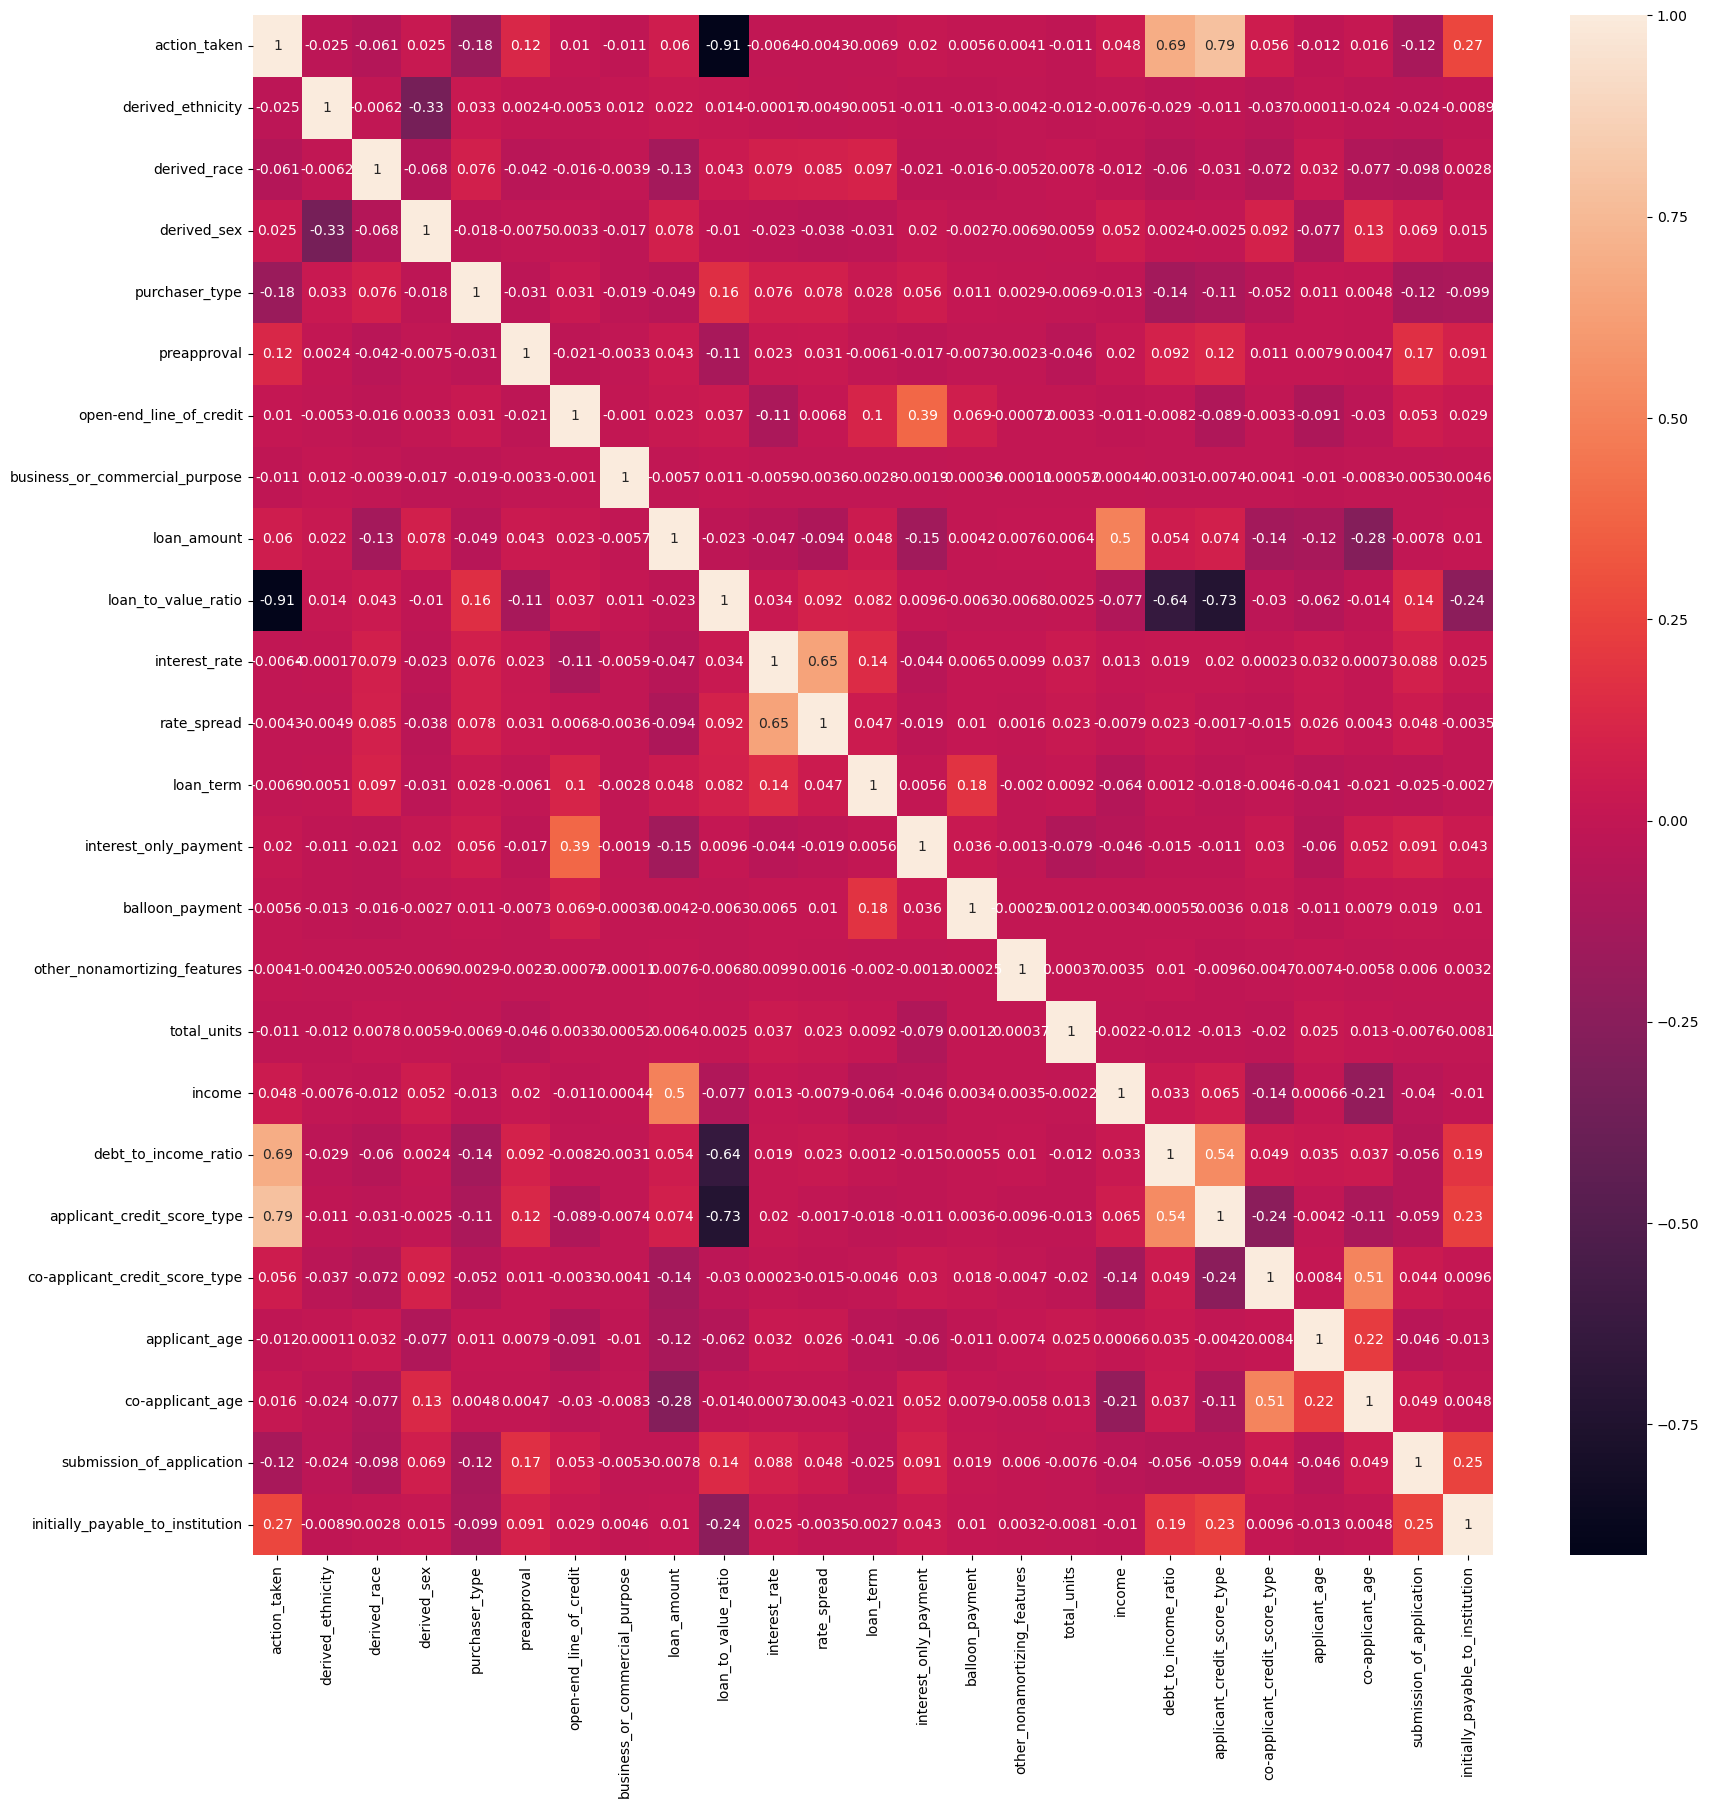

In [41]:
# visualizing correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot = True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12410 entries, 14 to 19470
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   action_taken                      12410 non-null  int64  
 1   derived_ethnicity                 12410 non-null  int32  
 2   derived_race                      12410 non-null  int32  
 3   derived_sex                       12410 non-null  int32  
 4   purchaser_type                    12410 non-null  int64  
 5   preapproval                       12410 non-null  int64  
 6   open-end_line_of_credit           12410 non-null  int64  
 7   business_or_commercial_purpose    12410 non-null  int64  
 8   loan_amount                       12410 non-null  float64
 9   loan_to_value_ratio               12410 non-null  float64
 10  interest_rate                     12410 non-null  float64
 11  rate_spread                       12410 non-null  float64
 12  loan_ter

The model data is reduced to have total 25 features including the label.

## 2. Model Building and Training

In [43]:
# separate label and model data
label = df['action_taken']
model_data = df.iloc[: , 1:]

### PCA Analysis

In [44]:
# Standardize features data before applying PCA
scaling=StandardScaler()

# Use fit and transform method
scaling.fit(model_data)
Scaled_data=scaling.transform(model_data)
# print("\nScaled data:", Scaled_data)

# Set the n_components=10
principal=PCA(n_components=10)
principal.fit(Scaled_data)
transformed_data =principal.transform(Scaled_data)

### Hierarchical Clustering

Test Run

In [45]:
model=None
# your code here
model = AgglomerativeClustering(n_clusters = 2, metric='euclidean',linkage = 'complete')
model.fit(transformed_data)
yp = model.labels_

In [46]:
def label_permute_compare(ytdf, yp,n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (0, 1), 0.74 
    """
    # your code here
    df_labels = np.unique(ytdf).tolist() # the true labels
    p_labels = np.unique(yp).tolist() # the random labels from prediction

    # generate all possible permutations of predicted labels
    # {'loan_originated': 0, ...}
    dict_perm_lst = []
    for perm in itertools.permutations(list(range(n))):
        dict_perm_lst.append(dict(zip(df_labels, perm))) 

    # find the mapping yielding best accuracy
    best_acc = 0
    labelorder = []
    for dict_perm in dict_perm_lst:
        yt_mapped = []
        for elt in ytdf:
            yt_mapped.append(dict_perm[elt])
        acc = accuracy_score(yt_mapped, yp)
        if acc > best_acc:
            best_acc = acc
            labelorder = list(dict_perm.values())

    return labelorder, best_acc

In [47]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

[0, 1] 0.8257856567284448


Hyperparameter Tuning for linkage and metric:

In [48]:
for linkage in ['ward', 'complete', 'average', 'single']:
    for metric in ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']:
        acc=0
        t0=time.time()
        try:
            model = AgglomerativeClustering(n_clusters=2,linkage=linkage,metric=metric).fit(transformed_data)
            labelorder, acc = label_permute_compare(label,model.labels_)   
            t1=time.time()
            print(t1-t0, linkage, metric, labelorder, acc)    
        except:    
            print(linkage, 'with', metric, 'not allowed.')

4.928956985473633 ward euclidean [0, 1] 0.987187751813054
ward with l1 not allowed.
ward with l2 not allowed.
ward with manhattan not allowed.
ward with cosine not allowed.
4.681374549865723 complete euclidean [0, 1] 0.8257856567284448
4.604254484176636 complete l1 [0, 1] 0.8257050765511684
4.605503797531128 complete l2 [0, 1] 0.8257856567284448
4.569226264953613 complete manhattan [0, 1] 0.8257050765511684
4.484738111495972 complete cosine [0, 1] 0.6044319097502014
4.895245552062988 average euclidean [0, 1] 0.8258662369057211
5.074737310409546 average l1 [0, 1] 0.8258662369057211
4.969928979873657 average l2 [0, 1] 0.8258662369057211
5.185145378112793 average manhattan [0, 1] 0.8258662369057211
4.294911861419678 average cosine [0, 1] 0.9953263497179694
1.1249847412109375 single euclidean [0, 1] 0.8258662369057211
0.9591779708862305 single l1 [0, 1] 0.8258662369057211
1.130556344985962 single l2 [0, 1] 0.8258662369057211
1.0436675548553467 single manhattan [0, 1] 0.8258662369057211
1.7

The best accuracy, 0.995, is produced when linkage is average and metric is cosine.

### K-means Clustering

In [49]:
start = time.time()
km = KMeans(n_clusters = 2, random_state = 0).fit(transformed_data)
labelorder, acc = label_permute_compare(label, km.labels_)
end = time.time()
print(labelorder, acc)
print(f"Time taken: {(end-start):.03f}s")

[0, 1] 0.9822723609991942
Time taken: 0.312s


K-means clustering gets high accuracy, 0.982, as the hierarchical clustering.

## 3. Results and Conclusion

In this project, I applied two clustering based methods to build predictive models for conventional loan eligibility of single family house. The dataset is the real data downloaded from FFIEC Home Mortgage Disclosure Act (HMDA) website and is Oakland County in Michigan.

The data exploratory analysis is intense. I looked up commentary of HMDA data in order to understanding the HMDA dataset, which helped me narrow down the important features. Imputing technique was applied on multiple features so as label encoding. I also removed uncorrelated features and highly correlated features via computing correlation between variables.

Principle components analysis was applied before clustering. Top ten components were kept to explain the data variance. In the first model, I utilized hierarchical clustering with hyperparameter tuning. The best accuracy is 0.995 when linkage is average and metric is cosine. Similarly, k-means clustering also generated great accuracy, 0.982 and it takes less time than hierarchical clustering.

Overall, the model produces great accuracy on predicting approval or denial of the mortgage. However, the scope of the model could expand further to predict more actions such as application approved but not accepted and application withdrawn. Besides, it could also explores
different type of loans like FHA and VA loans.

In summary, while my initial models offer valuable insights into home loan eligibility prediction, there is ample potential for further enhancement.